# Sentiment Analysis With Logistic Regression

In [ ]:
# importing module
import nltk
nltk.download("popular") #importing dataset
from nltk.corpus import twitter_samples
import numpy as np


positive_sample = twitter_samples.strings('positive_tweets.json')
negative_sample = twitter_samples.strings('negative_tweets.json')

# how many sample do we have?
print(len(positive_sample))
print(len(negative_sample))


Training And Testing Arrays Setup

In [ ]:
# train and test
trainx = positive_sample[:4000] + negative_sample[:4000]
testx = positive_sample[4000:] + negative_sample[4000:]

trainy = np.append(np.ones((len(positive_sample[:4000]), 1)), np.zeros((len(negative_sample[:4000]), 1)), axis=0)
testy = np.append(np.ones((len(positive_sample[4000:]), 1)), np.zeros((len(negative_sample[4000:]), 1)), axis=0)



Data Cleaning

In [ ]:
import re                                  
import string
from nltk.corpus import stopwords          
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer        

def text_process(tweet):
    tweet = re.sub(r'^RT[\s]+', '', tweet)
    tweet = re.sub(r'@[\w]+', '', tweet)
    tweet = re.sub(r'https?:\/\/.*[\r\n]*', '', tweet)
    tweet = re.sub(r'#', '', tweet)
    tokenizer = TweetTokenizer()
    tweet_tokenized = tokenizer.tokenize(tweet)
    stopwords_english = stopwords.words('english')
    stemmer = PorterStemmer() 

    pron = ['i', 'you','he','she','it','we','they']
    tweet_processed = [] 
    for word in tweet_tokenized:
      if word not in stopwords_english and word not in string.punctuation:
        word = word.lower()
        if word in pron: continue
        tweet_processed.append(stemmer.stem(word))

    return tweet_processed

print(negative_sample[1])
text_process(negative_sample[1])

Everything in the kids section of IKEA is so cute. Shame I'm nearly 19 in 2 months :(


['everyth',
 'kid',
 'section',
 'ikea',
 'cute',
 'shame',
 "i'm",
 'nearli',
 '19',
 '2',
 'month',
 ':(']

Mapping Dataset's Words Frequency


In [ ]:
freq = {}
words = []
for tweet in positive_sample:
  word_list = text_process(tweet)
  for word in word_list:
    words.append(word)

for word in words:
  if (word,1) in freq:
    freq[(word,1)] +=1
  else:
    freq[(word,1)] = 1

words = []
for tweet in negative_sample:
  word_list = text_process(tweet)
  for word in word_list:
    words.append(word)

for word in words:
  if (word,0) in freq:
    freq[(word,0)] +=1
  else:
    freq[(word,0)] = 1



In [ ]:
def features_extraction(tweet, freq):
    word_l = text_process(tweet)
    x = np.zeros((1, 3))
    x[0,0] = 1 
    for word in word_l:
        try:
            x[0,1] += freq[(word,1)]
        except:
            x[0,1] += 0
        try: 
            x[0,2] += freq[(word,0)]
        except:
            x[0,2] += 0
    return x

X = np.zeros((len(trainx), 3))

for i in range(len(trainx)):
    X[i, :] = features_extraction(trainx[i], freq)

print(X)

[[1.000e+00 3.764e+03 7.200e+01]
 [1.000e+00 4.488e+03 5.400e+02]
 [1.000e+00 3.778e+03 1.990e+02]
 ...
 [1.000e+00 1.840e+02 9.890e+02]
 [1.000e+00 2.560e+02 4.855e+03]
 [1.000e+00 2.400e+02 4.967e+03]]


Logistic Regression Implementation

In [ ]:
def sigmoid(x): 
    h = 1/(1+np.exp(-x))
    return h

def learn(x, y, alpha, num_iters):
    theta = np.zeros((3,1))
    m = x.shape[0]
    for i in range(0, num_iters):
        z = x @ theta
        h = sigmoid(z)
        J = -1/m*((y.T @ np.log(h))+((1-y).T @ np.log(1-h))) #Minimizing Cross entropy function
        theta -= (alpha/m)*(x.T@(h-y))
    return theta

theta = learn(X,trainy, 1e-9, 1000)
print(theta)

[[ 4.82032151e-08]
 [ 4.30241790e-04]
 [-4.53463529e-04]]


Testing and Validation

In [ ]:
def predict(tweet, freq, theta):
    x = features_extraction(tweet,freq)
    y_pred = sigmoid((x @ theta))
    return  1 if y_pred > 0.5 else 0

def test_accuracy(test_x, test_y, freq, theta):
    y_hat = []
    for tweet in test_x:   
        y_pred = predict(tweet, freq, theta)
        y_hat.append(y_pred)
        
    m = len(y_hat)
    y_hat = np.array(y_hat)
    y_hat = y_hat.reshape(m)
    test_y = test_y.reshape(m)
    
    c = y_hat == test_y
    j = 0
    for i in c:
        if i == True:
            j = j+1
    accuracy = j/m
    return y_hat ,accuracy

y_hat, accuracy = test_accuracy(testx, testy, freq, theta)
accuracy

0.997

In [ ]:
print(predict("Today is a beautiful day",freq,theta))

1


Confusion Matrix

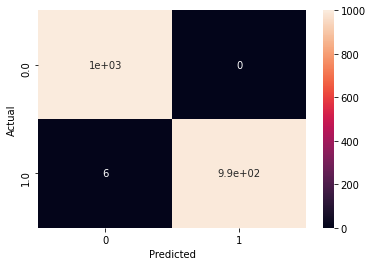

In [ ]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

data = {'y_Actual':    testy.reshape(len(y_hat)),
        'y_Predicted': y_hat
        }

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])

sn.heatmap(confusion_matrix, annot=True)
plt.show()